# Linear Regression

Try to apply a linear regression model to the merged otu table

In [1]:
import csv
import logging

import biom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from src import project_directory
from src.database import get_session, Sample

In [ ]:
session = get_session()
logging.basicConfig()
logging.getLogger('sqlalchemy.engine.Engine').setLevel(logging.ERROR)

Ok simply load otu table and then add tissue as metadata:

In [3]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [ ]:
# Get the list of samples in the OTU table
samples = table.ids(axis='sample')
print(samples[:10])

['H_10_S10_L001' 'H_11_S11_L001' 'H_12_S12_L001' 'H_13_S13_L001'
 'H_14_S14_L001' 'H_15_S15_L001' 'H_16_S16_L001' 'H_17_S17_L001'
 'H_18_S18_L001' 'H_19_S19_L001']


In [ ]:
# Query the database for samples in the samples list and collect the tissue
queried_samples = session.query(Sample).filter(Sample.sample_id.in_(samples)).all()
sample2tissue = {sample.sample_id: sample.dataset.tissue for sample in queried_samples}

In [ ]:
# Create an empty dataframe with the same indices as the samples
metadata = pd.DataFrame(index=samples)

# Add the tissue as new metadata
metadata['tissue'] = metadata.index.map(sample2tissue)

# Update the OTU table with the new metadata
table.add_metadata(metadata.to_dict(orient='index'), axis='sample')

# Verify that the tissue has been added correctly
print(table.metadata(axis='sample')[:3])

(defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fa6533e4040>, {'tissue': 'hindgut'}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fa6533e40d0>, {'tissue': 'hindgut'}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fa6533e4160>, {'tissue': 'hindgut'}))


Transform the otu table to a pandas dataframe and then add the tissue as metadata.
Table should be transposed to have samples as rows and otus as columns.

In [7]:
# Convert the OTU table to a dataframe
otu_df = pd.DataFrame(table.matrix_data.toarray(), index=table.ids(axis='observation'), columns=table.ids(axis='sample'))

# Add the tissue metadata as a new column
otu_df = otu_df.transpose()
otu_df['tissue'] = otu_df.index.map(sample2tissue)

In [8]:
otu_df["tissue"].value_counts()

tissue
milk       379
hindgut    141
rumen      118
Name: count, dtype: int64

Transform tables:

In [9]:
X = otu_df.drop(columns=["tissue"])
y = otu_df["tissue"]

In [10]:
# random_state: 
# https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Creating a model

In [11]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
model = LogisticRegression(solver="liblinear", max_iter=1000)
ovr_classifier = OneVsRestClassifier(model)

In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

In [ ]:
grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, verbose=1, cv=5)

In [15]:
grid_search.fit(scaled_X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [16]:
grid_search.best_params_

{'C': 100, 'penalty': 'l1'}

In [17]:
y_pred = grid_search.predict(scaled_X_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.984375
Classification Report:
              precision    recall  f1-score   support

     hindgut       1.00      0.92      0.96        37
        milk       0.97      1.00      0.99       114
       rumen       1.00      1.00      1.00        41

    accuracy                           0.98       192
   macro avg       0.99      0.97      0.98       192
weighted avg       0.98      0.98      0.98       192



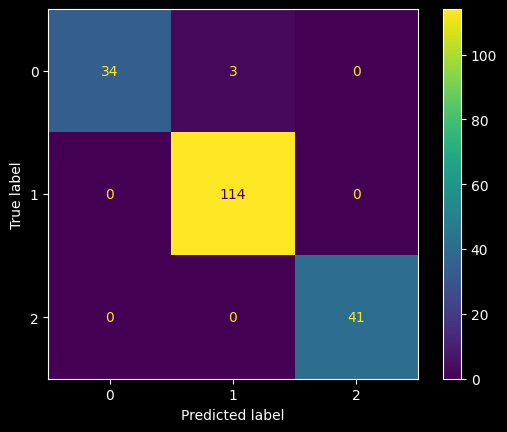

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Get the best model and save it to a file:

In [20]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, project_directory / "notebooks/logistic_regression_model.pkl")

['/home/cozzip/deep_micro_core/notebooks/logistic_regression_model.pkl']

Now try to collect the coefficients to identify the features that are more important for the model.

In [21]:
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({'Feature ID': X.columns, 'Coefficient': coefficients})
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
feature_importance.set_index('Feature ID', inplace=True)
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

,Coefficient,Importance
Feature ID,,
c630ec21cbed4dc65066e5e687ada385,1.011008,1.011008
cabb83f7cbe37d7d7cf59baea80b0371,0.329876,0.329876
ef76dbd4283a8d41d22917273c8f2d59,0.274941,0.274941
22ec988455bb85712fadb600a304979f,0.225395,0.225395
86ac9ae34fd63a83c3c3faf0b9611ae8,-0.222052,0.222052
2b2a11402dd3d812d86cec3e7ac39983,0.198203,0.198203
8948df324e12a5ad747350d8abb9eb56,0.193362,0.193362
5e70f4388d742e9a37fafe140bcd397f,0.164325,0.164325
8c6895b02271493713f168132959adf0,0.159755,0.159755


try to load the taxononies from file

In [22]:
taxonomy_file = project_directory / "merged_results/export/taxonomy/taxonomy.tsv"

with open(taxonomy_file, 'r') as handle:
    reader = csv.DictReader(handle, delimiter='\t')
    taxonomies = [row for row in reader]

taxonomies = {row['Feature ID']: row["Taxon"] for row in taxonomies}
taxonomies = {key: value.split(";")[:-1] for key, value in taxonomies.items()}
taxonomies = pd.DataFrame.from_dict(taxonomies, orient='index', columns=[f"Level_{i}" for i in range(1, 9)])
taxonomies.index.name = "Feature ID"
taxonomies.head()

,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,
00005da053b2c7b99c1f46889cbd7d33,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,,,,
000064ab480f315e268221d5ee0f9297,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Selenomonadaceae,Anaerovibrio,,
0000e116cc2f5406e876821a7c052ded,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Roseiflexaceae,,,
0002114dfc1325eafec7bed8250435ea,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,,,,
0002b1df012f092104af19e6cdb26d85,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotellaceae UCG-004,,


In [23]:
merged_df = feature_importance.merge(taxonomies, left_index=True, right_index=True, how="inner")
merged_df.to_csv(project_directory / "notebooks/feature_importance.csv", index=False)
merged_df.head()

,Coefficient,Importance,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,,,
c630ec21cbed4dc65066e5e687ada385,1.011008,1.011008,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,,,
cabb83f7cbe37d7d7cf59baea80b0371,0.329876,0.329876,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,[Ruminococcus] torques group,,
ef76dbd4283a8d41d22917273c8f2d59,0.274941,0.274941,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Rikenellaceae RC9 gut group,,
22ec988455bb85712fadb600a304979f,0.225395,0.225395,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,,
86ac9ae34fd63a83c3c3faf0b9611ae8,-0.222052,0.222052,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,,
